In [ ]:
import imageio as iio
from PIL import Image
import numpy as np
from skimage import data,io
import matplotlib.pyplot as plt
import math 
import random

In [ ]:
def imageTest(imageName):
    print("Hello TV Land! \n")
    
    img = iio.imread(imageName)
    
    iio.imwrite("testLenna.jpg", img)
#mageTest('/content/LENNA[2].bmp')

In [ ]:
im_gray = np.array(Image.open("testLenna.jpg").convert('L'))


In [ ]:
def select_matrix(window_size,image,centerpoint):
  grab_length = math.floor(window_size/2)
  selected_pixels = np.array([image[ centerpoint[0]-grab_length ][ centerpoint[1]-grab_length : centerpoint[1]+grab_length + 1 ]])
  for row in range(1,window_size):
    holder_pixels = np.array([image[ centerpoint[0]-grab_length + row ][ centerpoint[1]-grab_length : centerpoint[1]+grab_length + 1 ]])
    selected_pixels = np.append(selected_pixels,holder_pixels,axis=0)
  #print(selected_matrix)
  return selected_pixels  

In [ ]:
def makingcodebook(num,image,window_size):
  offset = math.floor(window_size/2)
  codebook = np.zeros((num,window_size,window_size))


  for n in range(0,num):
    xrandom = random.randint(0, int(image.shape[1]/window_size)-1)
    yrandom = random.randint(0, int(image.shape[0]/window_size)-1)

    codebook[n] = select_matrix(window_size,image,[offset + xrandom*window_size , offset + yrandom*window_size])
  return codebook
#print(codebook)

In [ ]:
def select(chosen,codebook):
  Index = 0
  initaldiff = abs((chosen - codebook[0]).sum())
  diff = initaldiff
  temp = 0
  for n in range(1,codebook.shape[0]):
    temp = abs((chosen - codebook[n]).sum())
    #print(temp)
    if(diff > temp):
      Index = n
      diff = temp
  return Index


In [ ]:
def edit(codebook,effect_size,learning_rate,index,chosen):
  width = math.floor((codebook.shape[0]*effect_size)/2)
  if(width == 0):
    width = 1
  center = index
  newcodebook = codebook.copy()
  spitial_std_dev = 1
  #print("width",width)
  if effect_size == 1:
    for n,pattern in enumerate(newcodebook):
      #using gaussian distribution
      #print("different pattern edit")
      gaussian = math.exp(-((n-center)**2)/(2*spitial_std_dev))
      #print(gaussian)
      diff = (newcodebook[n] - chosen)
      #print(newcodebook[n])
      #print(chosen)
      #print(diff)
      newcodebook[n] = newcodebook[n] - ((diff) * learning_rate * gaussian)
      #print(newcodebook[n])
  else:
    bottemwidth = index - width
    topwidth = index + width 
    #print("bot",bottemwidth)
    #print("top",topwidth)
    for n,pattern in enumerate(newcodebook):
      if n > bottemwidth-1 and n < topwidth+1 and n > -1 and n < len(codebook):
        #print(n)
        gaussian = math.exp(-((n-center)**2)/(2*spitial_std_dev))
        diff = (newcodebook[n] - chosen)
        newcodebook[n] = newcodebook[n] - ((diff) * learning_rate * gaussian)

  return newcodebook


In [ ]:
def random_editting(num,codebook,effect_size,learning_rate,image,window_size):
  offset = math.floor(window_size/2)
  tempcodebook = codebook.copy()
  for n in range(0,num):
    xrandom = random.randint(0, int(image.shape[1]/window_size)-1)
    yrandom = random.randint(0, int(image.shape[0]/window_size)-1)

    random_dither = select_matrix(window_size,image,[offset + xrandom*window_size , offset + yrandom*window_size])
    #print(type(random_dither))
    #print(type(tempcodebook))
    selectedIndex1 = select(random_dither,tempcodebook)
    #print("chosen Id",selectedIndex)
    tempcodebook = edit(tempcodebook,effect_size,learning_rate,selectedIndex1,random_dither)
  return tempcodebook

In [ ]:
def indeximage(image,window_size,codebook):
  offset = math.floor(window_size/2)
  indeximage = []
  for x in range(0,image.shape[0]//window_size):
    for y in range(0,image.shape[1]//window_size):
      chosen = select_matrix(window_size,image,[offset + x*window_size,offset + y*window_size])
      indeximage.append(select(chosen,codebook))
  indeximage = np.array(indeximage).reshape(image.shape[0]//window_size,image.shape[1]//window_size)
  return(indeximage)    

In [ ]:
def reconstruction(indexgray_image,codebook):
  window_size = codebook[0][0].shape[0]
  offset = window_size//2
  imagexsize = indexgray_image.shape[0] * window_size
  imageysize = indexgray_image.shape[1] * window_size
  image = np.zeros((imagexsize,imageysize))
  for x in range(0,imagexsize//window_size):
    for y in range(0,imageysize//window_size):
      middle = [offset + x*window_size,offset + y*window_size]
      indexgray = indexgray_image[x][y]
      for Mx in range(-offset,offset+1):
        for My in range(-offset,offset+1):
          image[middle[0]+Mx,middle[1]+My] = codebook[indexgray][Mx+offset][Mx+offset]
  return image


In [ ]:
def window_scheduler(learning_rate,int_num_iteration,image,dithersize,times_run,codebooksize):
  iteration = int_num_iteration
  Editcodebook = makingcodebook(codebooksize,image,dithersize)
  window_size = 1
  for run in range(0,times_run):
    Editcodebook = random_editting(iteration,Editcodebook,window_size,learning_rate,image,dithersize)
    iteration = iteration*2
    window_size = window_size/2
    learning_rate = learning_rate/2
  return Editcodebook

In [ ]:
def making2Dcodebook(num,image,window_size):
  offset = math.floor(window_size/2)
  codebook = np.zeros((num,num,window_size,window_size))


  for n in range(0,num):
    for x in range(0,num):
      xrandom = random.randint(0, int(image.shape[1]/window_size)-1)
      yrandom = random.randint(0, int(image.shape[0]/window_size)-1)

      codebook[n][x] = select_matrix(window_size,image,[offset + xrandom*window_size , offset + yrandom*window_size])
  return codebook
TwoD_codebook = making2Dcodebook(5,im_gray,3)
#print(TwoD_codebook)

In [ ]:
def Twoselect(chosen,codebook):
  Index = [0,0]
  initaldiff = abs((chosen - codebook[0][0]).sum())
  diff = initaldiff
  temp = 0
  for n in range(0,codebook.shape[0]):
    for x in range(0,codebook.shape[1]):
      temp = abs((chosen - codebook[n][x]).sum())
      #print(temp)
      if(diff > temp):

        Index = [int(n),int(x)]
        diff = temp
  return Index

In [ ]:
def Twoedit(codebook,effect_size,learning_rate,index,chosen):
  #print(codebook.shape[0])
  width = math.floor((codebook.shape[0]*effect_size)/2)
  #print(width)
  if(width == 0):
    width = 1
  center = index
  new2Dcodebook = codebook.copy()
  spitial_std_dev = 1
  #print("width",width)
  if effect_size == 1:
    for x in range(0,new2Dcodebook.shape[0]):
      for y in range(0,new2Dcodebook.shape[1]):
        #using gaussian distribution
        #print("different pattern edit")
        gaussian = math.exp(-((x-center[0])**2 + (y-center[1])**2)/(2*spitial_std_dev))
        #print(gaussian)
        diff = (new2Dcodebook[x][y] - chosen)
        #print(newcodebook[n])
        #print(chosen)
        #print(diff)
        new2Dcodebook[x][y] = new2Dcodebook[x][y] - ((diff) * learning_rate * gaussian)
        #print(newcodebook[n])
  else:
    bottemwidth = index[0] - width
    topwidth = index[0] + width
    leftwidth = index[1] - width
    rightwidth = index[1] + width
    #print("bot",bottemwidth)
    #print("top",topwidth)
    #print("left",leftwidth)
    #print("right",rightwidth)
    for x in range(0,new2Dcodebook.shape[0]):
      for y in range(0,new2Dcodebook.shape[1]): 
        if x > bottemwidth-1 and x < topwidth+1 and x > -1 and x < codebook.shape[0]:
          if y > leftwidth-1 and y < rightwidth+1 and y > -1 and y < codebook.shape[1]:
            #print(n)
            gaussian = math.exp(-((x-center[1])**2 + (y-center[1])**2)/(2*spitial_std_dev))
            diff = (new2Dcodebook[x][y] - chosen)
            new2Dcodebook[x][y] = new2Dcodebook[x][y] - ((diff) * learning_rate * gaussian)

  return new2Dcodebook
#Twoedit(TwoD_codebook,1/2,.1,[1,2],chosen)


In [ ]:
def Tworandom_editting(num,codebook,effect_size,learning_rate,image,window_size):
  offset = math.floor(window_size/2)
  new2Dcodebook = codebook.copy()
  for n in range(0,num):
    xrandom = random.randint(0, int(image.shape[1]/window_size)-1)
    yrandom = random.randint(0, int(image.shape[0]/window_size)-1)

    random_dither2 = select_matrix(window_size,image,[offset + xrandom*window_size , offset + yrandom*window_size])
    selectedIndex = Twoselect(random_dither2,new2Dcodebook)
    #print("chosen Id",selectedIndex)
    new2Dcodebook = Twoedit(new2Dcodebook,effect_size,learning_rate,selectedIndex,random_dither2)
  return new2Dcodebook

In [ ]:
def Twoindeximage(image,window_size,codebook):
  offset = math.floor(window_size/2)
  indeximage = np.zeros((image.shape[0]//window_size,image.shape[1]//window_size,2))
  for x in range(0,image.shape[0]//window_size):
    for y in range(0,image.shape[1]//window_size):
      chosen = select_matrix(window_size,image,[offset + x*window_size,offset + y*window_size])
      indeximage[x][y] = Twoselect(chosen,codebook)
  indeximage = np.array(indeximage).reshape(image.shape[0]//window_size,image.shape[1]//window_size,2)
  return(indeximage)


In [ ]:
def Tworeconstruction(indexgray_image,codebook):
  window_size = codebook[0][0].shape[0]
  offset = window_size//2
  imagexsize = indexgray_image.shape[0] * window_size
  imageysize = indexgray_image.shape[1] * window_size
  image = np.zeros((imagexsize,imageysize))
  for x in range(0,imagexsize//window_size):
    for y in range(0,imageysize//window_size):
      middle = [offset + x*window_size,offset + y*window_size]
      indexgray = indexgray_image[x][y]
      #print(indexgray)
      for Mx in range(-offset,offset+1):
        for My in range(-offset,offset+1):
          image[middle[0]+Mx,middle[1]+My] = codebook[int(indexgray[0])][int(indexgray[1])][Mx+offset][Mx+offset]
  return image

In [ ]:
def Twowindow_scheduler(learning_rate,int_num_iteration,image,dithersize,times_run,codebooksize):
  iteration = int_num_iteration
  Editcodebook = making2Dcodebook(codebooksize,image,dithersize)
  window_size = 1
  for run in range(0,times_run):
    Editcodebook = Tworandom_editting(iteration,Editcodebook,window_size,learning_rate,image,dithersize)
    iteration = iteration*2
    window_size = window_size/2
    learning_rate = learning_rate/2
  return Editcodebook

In [ ]:
iter = 5

TwoEntriescodebook = window_scheduler(.1,8,im_gray,3,iter,2)
TwoEntriesindexgray_image = indeximage(im_gray,3,TwoEntriescodebook)
TwoEntries1D = reconstruction(TwoEntriesindexgray_image,TwoEntriescodebook)

Twentycodebook = window_scheduler(.1,8,im_gray,3,iter,20)
Twentyindexgray_image = indeximage(im_gray,3,Twentycodebook)
TwentyEntries1D = reconstruction(Twentyindexgray_image,Twentycodebook)

Fiftycodebook = window_scheduler(.1,8,im_gray,3,iter,50)
Fiftyindexgray_image = indeximage(im_gray,3,Fiftycodebook)
FiftyEntries1D = reconstruction(Fiftyindexgray_image,Fiftycodebook)

/usr/local/lib/python3.9/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Text(0.5, 1.0, '50_1D')

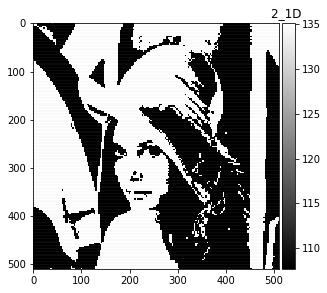

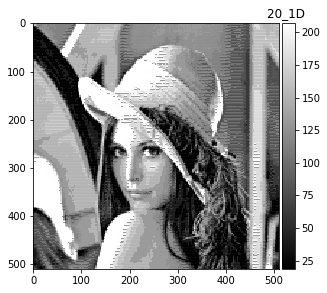

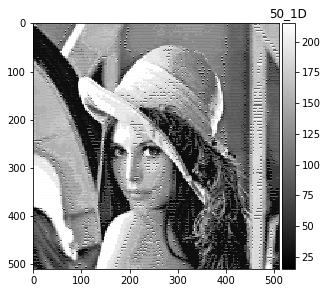

In [ ]:
plt.figure(1)
io.imshow(TwoEntries1D,cmap ="gray")
plt.title('2_1D ')

plt.figure(2)
io.imshow(TwentyEntries1D,cmap ="gray")
plt.title('20_1D ')

plt.figure(3)
io.imshow(FiftyEntries1D,cmap ="gray")
plt.title('50_1D')

In [ ]:
Three2Dcodebook = Twowindow_scheduler(.1,8,im_gray,3,2,3)
Threeindex2Dgray_image = Twoindeximage(im_gray,3,Three2Dcodebook)
Threewack2Dimage2 = Tworeconstruction(Threeindex2Dgray_image,Three2Dcodebook)

Five2Dcodebook = Twowindow_scheduler(.1,8,im_gray,3,2,5)
Fiveindex2Dgray_image = Twoindeximage(im_gray,3,Five2Dcodebook)
Fivewack2Dimage2 = Tworeconstruction(Fiveindex2Dgray_image,Five2Dcodebook)

Seven2Dcodebook = Twowindow_scheduler(.1,8,im_gray,3,2,7)
Sevenindex2Dgray_image = Twoindeximage(im_gray,3,Seven2Dcodebook)
Sevenwack2Dimage2 = Tworeconstruction(Sevenindex2Dgray_image,Seven2Dcodebook)

Text(0.5, 1.0, '2D 7')

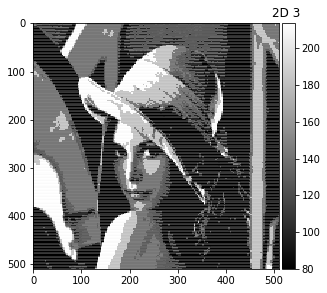

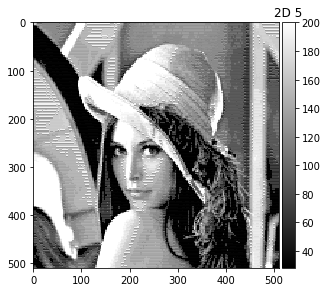

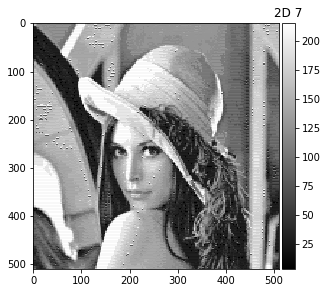

In [ ]:
plt.figure(1)
io.imshow(Threewack2Dimage2,cmap ="gray")
plt.title('2D 3 ')

plt.figure(2)
io.imshow(Fivewack2Dimage2,cmap ="gray")
plt.title('2D 5')

plt.figure(3)
io.imshow(Sevenwack2Dimage2,cmap ="gray")
plt.title('2D 7')

In [ ]:
fourtynineEntriescodebook = window_scheduler(.1,16,im_gray,3,10,25)
fourtynineEntriesindexgray_image = indeximage(im_gray,3,fourtynineEntriescodebook)
fourtynineEntries1D = reconstruction(fourtynineEntriesindexgray_image,fourtynineEntriescodebook)

In [ ]:
print(TwoEntriescodebook)
print(TwoEntriescodebook.reshape(6,3))

[[[134.50144791 134.18267547 134.08372919]
  [134.5699916  134.4636466  134.44840388]
  [134.24865651 134.47593949 135.1136596 ]]

 [[107.68384001 107.81113392 108.64632901]
  [107.76333407 107.7758472  108.74797646]
  [107.79353541 107.65590512 109.00875172]]]
[[134.50144791 134.18267547 134.08372919]
 [134.5699916  134.4636466  134.44840388]
 [134.24865651 134.47593949 135.1136596 ]
 [107.68384001 107.81113392 108.64632901]
 [107.76333407 107.7758472  108.74797646]
 [107.79353541 107.65590512 109.00875172]]


In [ ]:

twentyfive = fourtynineEntriescodebook.reshape(15,15)
Five2D = Five2Dcodebook.reshape(15,15)

Text(0.5, 1.0, '2D 5')

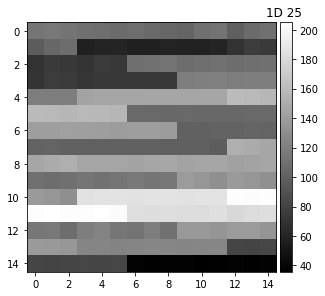

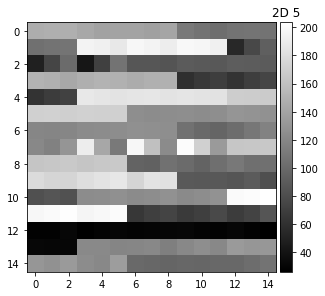

In [ ]:
plt.figure(4)
io.imshow(twentyfive,cmap ="gray")
plt.title('1D 25 ')

plt.figure(5)
io.imshow(Five2D,cmap ="gray")
plt.title('2D 5')